# Target PSF preparation for phase mask optimization

In [1]:
import numpy as np
import math
import timeit
import matplotlib.pyplot as plt
from scipy.misc import imsave
from scipy.misc import imresize
from scipy.ndimage import convolve
from skimage.transform import resize
%matplotlib inline

import os
os.environ["CUDA_VISIBLE_DEVICES"]="3"

import tensorflow as tf

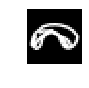

1599 0 255


In [2]:
doMNIST = False
if doMNIST:
    from tensorflow.examples.tutorials.mnist import input_data
    mnist = input_data.read_data_sets('MNIST_data', one_hot=True)
    i = np.random.randint(0, 10000)
    I = np.reshape(mnist.train.images[i], (28,28))

else:
    train_data = np.load('assets/quickdraw16_test.npy') # can use train dataset instead if downloaded
    i = np.random.randint(0, np.shape(train_data)[0])
    i = np.shape(train_data)[0]-1
    I = np.reshape(train_data[i], (28,28))


plt.imshow(I, cmap='gray')
plt.axis('off')
plt.gcf().set_size_inches(1, 1)
plt.show()
if doMNIST:
    print(mnist.train.labels[i])
else:
    print(i, np.min(I), np.max(I))

/home/sci/.local/lib/python3.5/site-packages/ipykernel_launcher.py:2: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  


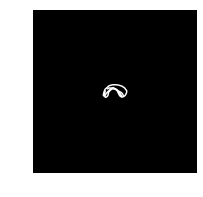

(160, 160)


In [3]:
# pad image
I = imresize(I, (28,28))
pad_amt = 66
Ipad = np.pad(I, ((pad_amt, pad_amt)), 'constant', constant_values = (0,0))
plt.imshow(Ipad, cmap='gray')
plt.axis('off')
plt.gcf().set_size_inches(3, 3)
plt.show()

print(np.shape(Ipad))

### Extract weights from checkpoint

In [4]:
from tensorflow.python.tools.inspect_checkpoint import print_tensors_in_checkpoint_file

def print_tensors_in_ckpt(ckpt_path):
    print_tensors_in_checkpoint_file(ckpt_path, 
                                          tensor_name='', all_tensors=False)
    
def load_variable_from_checkpoint(tensor_name, shape, ckpt_path, dtype=tf.float64):
    tf.reset_default_graph()

    # Load checkpoint from disk to compare phase shifts found by tensorflow
    tensor_graph = tf.get_variable(tensor_name, shape=shape, dtype=dtype)
    with tf.Session() as sess:
        saver = tf.train.Saver([tensor_graph])
        saver.restore(sess, ckpt_path)
        
        tensor_value = sess.run(tensor_graph)

    return tensor_value

## Tiled kernel

In [5]:
ckpt_path = 'checkpoints/20180515-145527/model.ckpt-10000'
print_tensors_in_ckpt(ckpt_path)

Variable (DT_INT32) []
beta1_power (DT_FLOAT) []
beta2_power (DT_FLOAT) []
h_conv1/kernel_00 (DT_FLOAT) [32,32,1,1]
h_conv1/kernel_00/Adam (DT_FLOAT) [32,32,1,1]
h_conv1/kernel_00/Adam_1 (DT_FLOAT) [32,32,1,1]
h_conv1/kernel_01 (DT_FLOAT) [32,32,1,1]
h_conv1/kernel_01/Adam (DT_FLOAT) [32,32,1,1]
h_conv1/kernel_01/Adam_1 (DT_FLOAT) [32,32,1,1]
h_conv1/kernel_02 (DT_FLOAT) [32,32,1,1]
h_conv1/kernel_02/Adam (DT_FLOAT) [32,32,1,1]
h_conv1/kernel_02/Adam_1 (DT_FLOAT) [32,32,1,1]
h_conv1/kernel_03 (DT_FLOAT) [32,32,1,1]
h_conv1/kernel_03/Adam (DT_FLOAT) [32,32,1,1]
h_conv1/kernel_03/Adam_1 (DT_FLOAT) [32,32,1,1]
h_conv1/kernel_10 (DT_FLOAT) [32,32,1,1]
h_conv1/kernel_10/Adam (DT_FLOAT) [32,32,1,1]
h_conv1/kernel_10/Adam_1 (DT_FLOAT) [32,32,1,1]
h_conv1/kernel_11 (DT_FLOAT) [32,32,1,1]
h_conv1/kernel_11/Adam (DT_FLOAT) [32,32,1,1]
h_conv1/kernel_11/Adam_1 (DT_FLOAT) [32,32,1,1]
h_conv1/kernel_12 (DT_FLOAT) [32,32,1,1]
h_conv1/kernel_12/Adam (DT_FLOAT) [32,32,1,1]
h_conv1/kernel_12/Adam_1 (DT

In [6]:
# load tiled PSF
# make sure these dimensions match the variable size printed above
# this will depend on how you chose to kernel size during PSF optimization
kernels = np.zeros((32, 32, 16))
count = 0
for i in range(4):
    for j in range(4):
        varname = 'h_conv1/kernel_' + str(i) + str(j)
        var = load_variable_from_checkpoint(varname, [32,32,1,1], ckpt_path, dtype=tf.float32)
        kernels[:,:,count] = np.abs(var.squeeze())
        count += 1
        


INFO:tensorflow:Restoring parameters from checkpoints/20180515-145527/model.ckpt-10000
INFO:tensorflow:Restoring parameters from checkpoints/20180515-145527/model.ckpt-10000
INFO:tensorflow:Restoring parameters from checkpoints/20180515-145527/model.ckpt-10000
INFO:tensorflow:Restoring parameters from checkpoints/20180515-145527/model.ckpt-10000
INFO:tensorflow:Restoring parameters from checkpoints/20180515-145527/model.ckpt-10000
INFO:tensorflow:Restoring parameters from checkpoints/20180515-145527/model.ckpt-10000
INFO:tensorflow:Restoring parameters from checkpoints/20180515-145527/model.ckpt-10000
INFO:tensorflow:Restoring parameters from checkpoints/20180515-145527/model.ckpt-10000
INFO:tensorflow:Restoring parameters from checkpoints/20180515-145527/model.ckpt-10000
INFO:tensorflow:Restoring parameters from checkpoints/20180515-145527/model.ckpt-10000
INFO:tensorflow:Restoring parameters from checkpoints/20180515-145527/model.ckpt-10000
INFO:tensorflow:Restoring parameters from c

(160, 160)


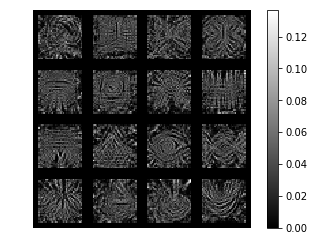

In [7]:
# tile individual kernels on one large PSF
kernels_pad = [np.pad(kernels[:,:,i], [[4, 4], [4, 4]], mode='constant') for i in range(16)]
psf = np.concatenate([np.concatenate(kernels_pad[i*4:i*4+4], axis=1) for i in range(4)], axis=0)

pad = 0
psf = np.pad(psf, [[pad, pad], [pad, pad]], mode='constant')
print(np.shape(psf))

plt.imshow(psf, cmap='gray')
plt.colorbar()
plt.axis('off')
plt.show()

# imsave('assets/tiled_psf.png', psf/np.max(psf), cmap='gray')

In [29]:
# save PSF for phase mask optimization
# can choose to pad this before saving as .npy for phase mask opt
np.save('assets/quickdraw16_tiledpsf.npy', psf)

In [3]:
# only need to run this to generate padded images for phase mask optimization
# generate training images for mask optimization
train_data = np.load('assets/quickdraw16_test.npy') # change to quickdraw16_train.npy after downloaded
os.mkdir('assets/quickdraw16_192')

for j in range(100): # change to 9999 or however many after train download
    # nextImage=True
    # while nextImage:
    #     i = np.random.randint(0, 20000)
    #     if np.argmax(mnist.train.labels[i]) > 0:
    #         nextImage = False
        
    i = np.random.randint(0, np.shape(train_data)[0])
    I = np.reshape(train_data[i], (28,28))
    # I = imresize(I, (28,28))
    
    # pad image
    pad_amt = 82 # 50
    Ipad = np.pad(I, ((pad_amt, pad_amt)), 'constant', constant_values = (0,0))
    
    imsave('assets/quickdraw16_192/im_%04d.png' % (j), Ipad)


/home/sci/.local/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


# Visualization of phase mask optimization

### Extract phase mask

In [151]:
# checkpoint after running phase mask optimization (e.g onn_maskopt.py)
ckpt_path = '/media/data/checkpoints/onn/quickdraw16/singleconv/maskopt/tiledpsf_4x/20180515-233527/PhaseMask_ONN.ckpt-150000'
print_tensors_in_ckpt(ckpt_path)

Variable (DT_INT32) []
beta1_power (DT_FLOAT) []
beta2_power (DT_FLOAT) []
model/maskopt/phase_mask_height/height_map_sqrt (DT_DOUBLE) [1,768,768,1]
model/maskopt/phase_mask_height/height_map_sqrt/Adam (DT_DOUBLE) [1,768,768,1]
model/maskopt/phase_mask_height/height_map_sqrt/Adam_1 (DT_DOUBLE) [1,768,768,1]



INFO:tensorflow:Restoring parameters from /media/data/checkpoints/onn/quickdraw16/singleconv/maskopt/tiledpsf_4x/20180515-233527/PhaseMask_ONN.ckpt-150000
0.009799960085454452 0.0 mean: 3.057081575168018e-06


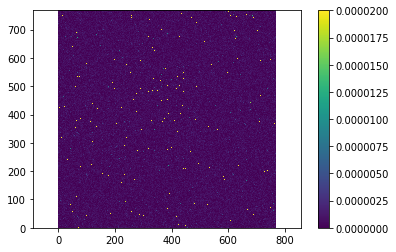

In [152]:
# Load optimized height map
dim = 192 # 128
scale = 4
waveres = dim*scale

varname = 'model/maskopt/phase_mask_height/height_map_sqrt'
# varname = 'opt_conv1/phase_mask_height/height_map_sqrt'
height_map_sqrt = load_variable_from_checkpoint(varname, [1,waveres,waveres,1], ckpt_path, dtype=tf.float64)
height_map = np.square(height_map_sqrt.squeeze())        
    
    
print(np.max(height_map), np.min(height_map), 'mean:', np.mean(height_map))
plt.pcolor(height_map, vmin=0, vmax=2e-5)
plt.colorbar()
plt.axis('equal')
plt.show()

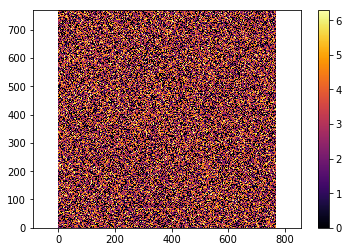

In [153]:
# Visualize phase mask instead
wavelength = 550 * 1e-9
n = 1.5090
delta_n = n - 1.0002777
phi = (2*np.pi*delta_n/wavelength) * height_map
phimax = 2*np.pi;
phi = np.mod(phi, phimax)

plt.pcolor(phi, vmin=0, vmax=phimax, cmap='inferno')
plt.colorbar()
plt.axis('equal')
plt.show()


In [154]:
# phase mask PSF
atf = np.fft.ifftshift(np.exp(1j*phi))
psf_pm_full = np.square(np.abs(np.fft.ifft2(atf)))
psf_pm_full = np.fft.fftshift(psf_pm_full)

In [155]:
np.max(psf_pm)

1.209993178003401e-05

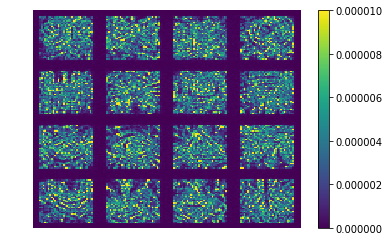

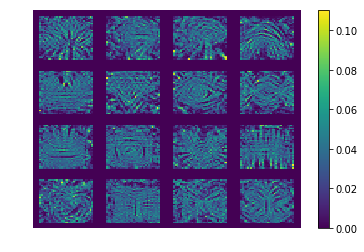

In [157]:
# resize psf
psf_pm = resize(psf_pm_full, (dim, dim))
unpad_psf = 16
psf_pm = psf_pm[unpad_psf:-unpad_psf,unpad_psf:-unpad_psf]
np.max(psf_pm)
plt.pcolor(psf_pm, vmin=0, vmax=1e-5)
plt.colorbar()
plt.axis('off')
plt.show()

plt.pcolor(psf, vmin=0, vmax=.11)
plt.colorbar()
plt.axis('off')
plt.show()

In [158]:
# if you want to save as a PNG
from matplotlib.pyplot import imsave
# imsave('pm_phase.png', phi/np.max(phi), cmap='inferno')
unpad = 16*scale
# imsave('h/tiled_pm_psf.png', psf_pm_full[unpad:-unpad, unpad:-unpad], vmin = 0.0, vmax = 9e-6, cmap='gray')
print(np.shape(height_map), np.shape(phi))

(768, 768) (768, 768)


1104
[[0.13359111 0.14935826 0.13589243 0.14210534]
 [0.13250173 0.14510827 0.14012953 0.14528012]
 [0.14660648 0.13721038 0.15205653 0.14169223]
 [0.13846348 0.13493977 0.13411839 0.13829994]]


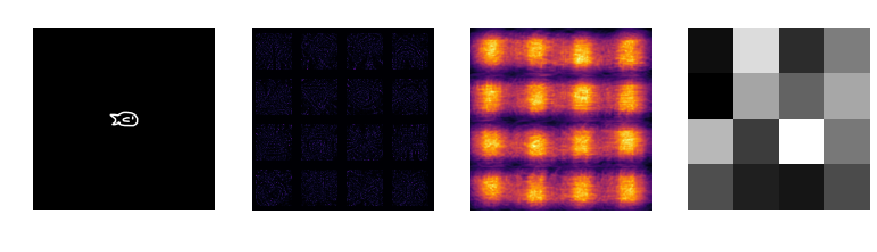

In [163]:
# Test phase mask with a sample convolution
from scipy.signal import fftconvolve

if doMNIST:
    nextImage=True
    while nextImage:
        i = np.random.randint(0, 10000)
        if np.argmax(mnist.train.labels[i]) > 0:
            nextImage = False
    I = np.reshape(mnist.train.images[i], (28,28))
else:
    i = np.random.randint(0, np.shape(train_data)[0])
    print(i)
    I = np.reshape(train_data[i], (28,28))
            
pad_amt = 66 # 82
Ipad = np.pad(I, ((pad_amt, pad_amt)), 'constant', constant_values = (0,0)) 

fig, ax = plt.subplots(nrows=1, ncols=4)
plt.subplot(141)
plt.imshow(Ipad, cmap='gray')
plt.axis('off')

psf_pm = np.fliplr(np.flipud(psf_pm))

# convolve
plt.subplot(142)
plt.pcolor(psf_pm, vmin=0, vmax=.0001, cmap='inferno')
plt.axis('off'), plt.axis('equal')


Ipad_pad = np.pad(Ipad, ((pad_amt, pad_amt)), 'constant', constant_values = (0,0)) 
psf_pad = np.pad(psf_pm, ((pad_amt, pad_amt)), 'constant', constant_values = (0,0)) 
Iconv = fftconvolve(Ipad_pad, psf_pad, mode='same')
Iconv = Iconv[pad_amt:-pad_amt, pad_amt:-pad_amt]

plt.subplot(143)
plt.pcolor(np.fliplr(np.flipud(Iconv)), cmap='inferno')
plt.axis('off'), plt.axis('equal')

# calculate scores
Iconv_vsplit = np.vsplit(Iconv, 4)
Iconv_split = np.concatenate((np.hsplit(Iconv_vsplit[0], 4), 
                             np.hsplit(Iconv_vsplit[1], 4), 
                             np.hsplit(Iconv_vsplit[2], 4),
                             np.hsplit(Iconv_vsplit[3], 4)), axis=0)
scores = np.max(Iconv_split, axis=(1,2))

# print('correct:', np.argmax(mnist.train.labels[i]))
# print('predicted:', np.argmax(scores)+1)
print(np.reshape(scores, [4, 4]))
categories = ['apple', 'book', 'bowtie', 'butterfly', 
              'cake', 'camera', 'cat', 'chair', 
              'crown', 'diamond','eye', 'fish', 
              'hand', 'icecream', 'lollipop','rainbow']

plt.subplot(144)
plt.imshow(np.reshape(scores, [4,4]), cmap='gray')
plt.axis('off')
plt.axis('equal')

plt.gcf().set_size_inches(15, 4)
plt.show()

In [39]:
# if you want to save the images
# imsave('Iconv.png', Iconv/np.max(Iconv), cmap='inferno')
# imsave('Ipad.png', Ipad, cmap='gray')